In [11]:
%load_ext autoreload
%autoreload 2
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pandas as pd
import numpy as np
from src.utils import flatten_level_columns as flc
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 140
import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns",999)
pd.set_option("display.max_rows",100)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# FCT defs

## count/explo

In [249]:
def count_class(df):
    tmp = df.groupby('agg_label').count()
    display(tmp)
    return tmp
def get_top_HLA(df, n=10):
    hla_col = 'HLA' if 'HLA' in df.columns else 'mhc_allele name'
    pep_col = 'Peptide' if 'Peptide' in df.columns else 'epitope_description'
    tmp = ','.join([x.replace(':','').replace('*','').replace('HLA-','')\
              for x in df.groupby(hla_col)[[pep_col]].agg('count').sort_values(pep_col, ascending=False).head(n).index])
    print(tmp)
    return tmp

## IC/MIA


In [242]:
AA_KEYS = [x for x in 'ARNDCQEGHILKMFPSTWYV']

CHAR_TO_INT = dict((c,i) for i,c in enumerate(AA_KEYS))
INT_TO_CHAR = dict((i,c) for i,c in enumerate(AA_KEYS))

def onehot_encode(sequence):
    int_encoded = [CHAR_TO_INT[char] for char in sequence]
    onehot_encoded = list() 
    for value in int_encoded:
        letter = [0 for _ in range(len(AA_KEYS))]
        letter[value] = 1
        onehot_encoded.append(letter)
    return np.array(onehot_encoded)

def onehot_decode(onehot_sequence):
    return ''.join([INT_TO_CHAR[k.item()] for k in onehot_sequence.argmax(axis=1)])

def onehot_batch_encode(sequences):
    return np.stack([onehot_encode(x) for x in sequences])

def onehot_batch_decode(onehot_sequences):
    return np.stack([onehot_decode(x) for x in onehot_sequences])

def compute_pfm(sequences):
    """
    Computes the position frequency matrix given a list of sequences
    """
    N = len(sequences)
    onehot_seqs = onehot_batch_encode(sequences)
    return onehot_seqs.sum(axis=0)/N

def compute_ic_position(matrix, position):
    row = matrix[position]
    row_log20 = np.nan_to_num(np.log(row) / np.log(20), neginf=0)
    IC = 1+ np.sum(row*row_log20)
    return IC

def compute_ic_sequence(matrix):
    """
    returns the IC for sequences of a given length based on the frequency matrix
    """
    return np.array([compute_ic_position(matrix, pos) for pos in range(matrix.shape[0])])

def get_mia(IC_array, threshold=0.3):
    return np.where(IC_array<threshold)[0]

## cedar filtering

In [243]:
def query_ELIS(df):
    return df.query('`assay_method/technique` in ["ELISPOT", "ELISA"]').sort_values('epitope_description')

def keep_full_HLA(df):
    return df.query('`mhc_allele name`.str.contains(":")', engine = 'python')

def get_dupe_unique_df(df):
    """
    From the source df, get the unique (keeping first) AND the duplicates df, and the common indices
    """
    dup_df = df.loc[df.duplicated(subset='epitope_description', keep=False)].sort_values('epitope_description')
    unique_df = df.drop_duplicates(subset='epitope_description', keep ='first')
    common_indices = dup_df.index.join(unique_df.index, how = 'inner')
    return unique_df, dup_df, common_indices

def get_agg_label(dup_df):
    dup_df['label'] = dup_df['assay_qualitative measure'].apply(lambda x: 1 if 'Pos' in x else 0)
    agg_label = dup_df.groupby('epitope_description').agg({'label':"max"})
    gb = dup_df.groupby(['epitope_description', 'label']).agg({'label':"count"}).rename(columns={'label':'count'})
    return agg_label

def get_agg(dup_df):
    dup_df['label'] = dup_df['assay_qualitative measure'].apply(lambda x: 1 if 'Pos' in x else 0)
    
    gb = dup_df.groupby(['epitope_description', 'label']).agg({'label':"count"}).rename(columns={'label':'count'})#.reset_index()
    gb['percentage_pos'] = gb/gb.groupby(['epitope_description']).agg({'count':"sum"})
    agg = gb.reset_index().groupby(['epitope_description']).agg({'label':'max', 'percentage_pos':"max"}).rename(columns={'label':'agg_label'})
    agg.loc[agg['agg_label']==0, 'percentage_pos']=0
    agg['total'] = gb.reset_index().groupby('epitope_description').agg({'count':"sum"})
    return agg

def assign_agg_metrics(unique_df, agg_df, common_indices):
    unique_df['agg_label'] = unique_df['assay_qualitative measure'].apply(lambda x: 1 if 'Pos' in x else 0)
    unique_df['total_count'] = 1
    unique_df['percentage_pos'] = unique_df['agg_label']
    unique_df.loc[common_indices, 'agg_label'] = agg['agg_label'].values
    unique_df.loc[common_indices, 'total_count'] = agg['total'].values
    unique_df.loc[common_indices, 'percentage_pos'] = agg['percentage_pos'].values
    return unique_df

# init

In [304]:
# Removing entries with X and saving to pep/df file for hobohm1
lst=[]
for k,v in scored.items():
    lst.append(v.loc[~(v['Peptide'].str.contains("X"))])

In [306]:
hp_no_x = pd.concat(lst)

In [308]:
hp_no_x.to_csv('../../../human_proteome_df.csv')
hp_no_x['Peptide'].to_csv('../../../human_proteome_df.pep', index=False, header=False)

In [3]:
scored_9mers = pd.concat([pd.read_csv(f'../output/9mers_humanproteome_chunk_{x}scored.txt') for x in [0, 1, 2, 3]])
scored_8mers = pd.concat([pd.read_csv(f'../output/8mers_humanproteome_chunk_{x}scored.txt') for x in [0, 1, 2, 3]])
scored_10mers = pd.concat([pd.read_csv(f'../output/10mers_humanproteome_chunk_{x}scored.txt') for x in [0, 1, 2, 3]])
scored_11mers = pd.concat([pd.read_csv(f'../output/11mers_humanproteome_chunk_{x}scored.txt') for x in [0, 1, 2, 3]])
scored_12mers = pd.concat([pd.read_csv(f'../output/12mers_humanproteome_chunk_{x}scored.txt') for x in [0, 1, 2, 3]])

In [4]:
scored_9mers.query('HLA=="HLA-A02:01" and EL_Rank<=0.1')['Peptide'].to_csv('A0201_rank01.txt', index=False, header=False)

In [5]:
for x in scored_9mers.HLA.unique():
    print(f'{x}, N = {len(scored_9mers.query("HLA == @x and EL_Rank < 0.5"))}')

HLA-B35:01, N = 92237
HLA-B15:01, N = 103266
HLA-B07:02, N = 105471
HLA-A02:06, N = 109028
HLA-A02:01, N = 110177
HLA-A24:02, N = 92307
HLA-A03:01, N = 58403
HLA-A01:01, N = 50808
HLA-B27:05, N = 102726
HLA-A11:01, N = 94623


# Information content

In [6]:
AA_KEYS = [x for x in 'ARNDCQEGHILKMFPSTWYV']

CHAR_TO_INT = dict((c,i) for i,c in enumerate(AA_KEYS))
INT_TO_CHAR = dict((i,c) for i,c in enumerate(AA_KEYS))

def onehot_encode(sequence):
    int_encoded = [CHAR_TO_INT[char] for char in sequence]
    onehot_encoded = list() 
    for value in int_encoded:
        letter = [0 for _ in range(len(AA_KEYS))]
        letter[value] = 1
        onehot_encoded.append(letter)
    return np.array(onehot_encoded)

def onehot_decode(onehot_sequence):
    return ''.join([INT_TO_CHAR[k.item()] for k in onehot_sequence.argmax(axis=1)])

def onehot_batch_encode(sequences):
    return np.stack([onehot_encode(x) for x in sequences])

def onehot_batch_decode(onehot_sequences):
    return np.stack([onehot_decode(x) for x in onehot_sequences])

def compute_pfm(sequences):
    """
    Computes the position frequency matrix given a list of sequences
    """
    N = len(sequences)
    onehot_seqs = onehot_batch_encode(sequences)
    return onehot_seqs.sum(axis=0)/N

def compute_ic_position(matrix, position):
    row = matrix[position]
    row_log20 = np.nan_to_num(np.log(row) / np.log(20), neginf=0)
    IC = 1+ np.sum(row*row_log20)
    return IC

def compute_ic_sequence(matrix):
    """
    returns the IC for sequences of a given length based on the frequency matrix
    """
    return np.array([compute_ic_position(matrix, pos) for pos in range(matrix.shape[0])])

def get_mia(IC_array, threshold=0.3):
    return np.where(IC_array<threshold)[0]

In [7]:
results = {'8mers':scored_8mers,
           '9mers':scored_9mers,
           '10mers':scored_10mers,
           '11mers':scored_11mers}

In [8]:
data=[]
for k in [8, 9, 10, 11]:
    for HLA in scored_9mers.HLA.unique():
        peptides=[x for x in results[f'{k}mers'].query("HLA == @HLA and EL_Rank<=1.0")['Peptide'] if "X" not in x]
        ics = compute_ic_sequence(compute_pfm(peptides))
        data.append([k, HLA, ics])
results = pd.DataFrame(data, columns = ['k', 'HLA', 'positions'])

In [9]:
a0201 = scored_9mers.query('HLA == "HLA-A02:01" and EL_Rank < 0.1')['Peptide'].values.flatten()

In [18]:
vals = compute_ic_sequence(compute_pfm(a0201))
print('information content for rank <0.1, HLA-A*02:01')
print(f'{[x.round(4) for x in vals]}')

information content for rank <0.1, HLA-A*02:01
[0.129, 0.8936, 0.0909, 0.1966, 0.044, 0.1296, 0.0769, 0.0868, 0.5991]


In [ ]:
get_mia(results.query('HLA == "HLA-A02:01" and k == 9')['positions'].item(), threshold=0.3)

In [ ]:
results.rename(columns={'positions':'ics'}).to_csv('../output/df_ic_positions.csv')

# cedar

In [21]:
COLS= ['epitope_epitope id', 'epitope_description', 'epitope_starting position', 'epitope_ending position', 'epitope_antigen name', 
       'epitope_parent protein', 'related object_epitope relationship', 'related object_description', 'related object_parent protein',
       'mhc_allele name', 'mhc_allele evidence code', 'assay_method/technique', 'agg_label', 'total_count', 'percentage_pos']
# read dfs
epitopes = flc(pd.read_csv('../data/epitope_export_mhc1_TCR-MHC_220510.csv', header = [0,1]))
mhc = flc(pd.read_csv('../data/mhc_ligand_export_220510.csv', header = [0,1]))
df_tc = flc(pd.read_csv('../data/tcell_export_mhc1_220510.csv', header = [0,1]))

# refilters pos TC list, pos = positive at least once to ELISPOT or ELISA
# define neg as having a neg test and NO positive
# filters duplicates and keep only single entry with new label
elis = keep_full_HLA(query_ELIS(df_tc))
unique_df, dup_df, common_indices = get_dupe_unique_df(keep_full_HLA(elis))

# Get aggregated label from duplicated epitope entries 
# Keep unique entries and re-assign labels
agg = get_agg(dup_df)
unique_df = assign_agg_metrics(unique_df, agg, common_indices)
filtered_df = unique_df[COLS]
filtered_df['len'] = filtered_df['epitope_description'].apply(lambda x: len(x))
filtered_df = filtered_df.query('len>=8 and len <=12')

## explo/checks

In [22]:
df_tc.columns[:10]

Index(['reference_t cell id', 'reference_reference id', 'reference_type',
       'reference_pubmed id', 'reference_authors', 'reference_journal',
       'reference_date', 'reference_title', 'reference_submission id',
       'epitope_epitope id'],
      dtype='object')

In [221]:
df_tc.groupby(['epitope_description', 'mhc_allele name']).count()

reference_t cell id  \
epitope_description       mhc_allele name                        
AAAAAAQQIQV               HLA-B*07:02                        1   
AAAAAHQGVWGSLLLPAPPAGLAPA HLA class I                        1   
AAAAQQIQV                 HLA-A*02:01                        1   
                          HLA-B*07:02                        1   
AADHRQLQL                 HLA-C*05:01                        1   
...                                                        ...   
YYSKNLNSFF                HLA-A*24:02                        2   
YYSPQAQTL                 HLA-A*24:02                        1   
YYTVRNFTL                 HLA-A*24:02                        3   
YYYRFVIGL                 HLA-C*07:02                        1   
alpha-galactosylceramide  HLA-A*02:01                        1   

                                           reference_reference id  \
epitope_description       mhc_allele name                           
AAAAAAQQIQV               HLA-B*07:02                           1   
AAAAAHQGVWGSLLLPAPPAGLAPA HLA class I                           1   
AAAAQQIQV                 HLA-A*02:01                           1   
                          HLA-B*07:02                           1   
AADHRQLQL                 HLA-C*05:01                           1   
...                                                           ...   
YYSKNLNSFF                HLA-A*24:02                           2   
YYSPQAQTL                 HLA-A*24:02                           1   
YYTVRNFTL                 HLA-A*24:02                           3   
YYYRFVIGL                 HLA-C*07:02                           1   
alpha-galactosylceramide  HLA-A*02:01                           1   

                                           reference_type  \
epitope_description       mhc_allele name                   
AAAAAAQQIQV               HLA-B*07:02                   1   
AAAAAHQGVWGSLLLPAPPAGLAPA HLA class I                   1   
AAAAQQIQV                 HLA-A*02:01                   1   
                          HLA-B*07:02                   1   
AADHRQLQL                 HLA-C*05:01                   1   
...                                                   ...   
YYSKNLNSFF                HLA-A*24:02                   2   
YYSPQAQTL                 HLA-A*24:02                   1   
YYTVRNFTL                 HLA-A*24:02                   3   
YYYRFVIGL                 HLA-C*07:02                   1   
alpha-galactosylceramide  HLA-A*02:01                   1   

                                           reference_pubmed id  \
epitope_description       mhc_allele name                        
AAAAAAQQIQV               HLA-B*07:02                        1   
AAAAAHQGVWGSLLLPAPPAGLAPA HLA class I                        1   
AAAAQQIQV                 HLA-A*02:01                        1   
                          HLA-B*07:02                        1   
AADHRQLQL                 HLA-C*05:01                        1   
...                                                        ...   
YYSKNLNSFF                HLA-A*24:02                        2   
YYSPQAQTL                 HLA-A*24:02                        1   
YYTVRNFTL                 HLA-A*24:02                        3   
YYYRFVIGL                 HLA-C*07:02                        1   
alpha-galactosylceramide  HLA-A*02:01                        1   

                                           reference_authors  \
epitope_description       mhc_allele name                      
AAAAAAQQIQV               HLA-B*07:02                      1   
AAAAAHQGVWGSLLLPAPPAGLAPA HLA class I                      1   
AAAAQQIQV                 HLA-A*02:01                      1   
                          HLA-B*07:02                      1   
AADHRQLQL                 HLA-C*05:01                      1   
...                                                      ...   
YYSKNLNSFF                HLA-A*24:02                      2   
YYSPQAQTL                 HLA-A*24:02                    

In [23]:
df_tc[['reference_pubmed id', 'reference_authors', 'reference_journal',
       'reference_date', 'reference_title','epitope_description']+[x for x in df_tc.columns if 'assay' in x]]

,reference_pubmed id,reference_authors,reference_journal,reference_date,reference_title,epitope_description,assay_location of assay data in the manuscript,assay_method/technique,assay_assay group,assay_units,assay_qualitative measure,assay_measurement inequality,assay_quantitative measurement,assay_number of subjects tested,assay_number of subjects responded,assay_response frequency,tcr_assayed tcr molecule name,assay antigen_antigen epitope relation,assay antigen_antigen object type,assay antigen_antigen description,assay antigen_starting position,assay antigen_ending position,assay antigen_non-peptidic antigen chebi id,assay antigen_antigen source molecule name,assay antigen_protein parent name,assay antigen_protein parent accession,assay antigen_antigen organism name,assay antigen_organism species name,assay antigen_organism species id,assay comments_assay comments
0,15538043,Andr&eacute; Jaramillo; Kishore Narayanan; Lac...,Breast Cancer Res Treat,2004,Recognition of HLA-A2-restricted mammaglobin-A...,LIYDSSLCDL,Table 3,ELISPOT,IFNg release,NaN,Positive,NaN,NaN,8.0,NaN,NaN,NaN,Epitope,Linear peptide,LIYDSSLCDL,83.0,92.0,NaN,Mammaglobin-A precursor,Mammaglobin-A,Q13296,Homo sapiens,Homo sapiens,9606.0,5 out of 8 (62.5%) breast cancer patients show...
1,15538043,Andr&eacute; Jaramillo; Kishore Narayanan; Lac...,Breast Cancer Res Treat,2004,Recognition of HLA-A2-restricted mammaglobin-A...,LIYDSSLCDL,Figure 2,51 chromium,cytotoxicity,NaN,Positive,NaN,NaN,NaN,NaN,NaN,NaN,Epitope,Linear peptide,LIYDSSLCDL,83.0,92.0,NaN,Mammaglobin-A precursor,Mammaglobin-A,Q13296,Homo sapiens,Homo sapiens,9606.0,Immunodominance was evaluated in CD8+ cell lin...
2,15382068,Martina Berg; Eilon Barnea; Arie Admon; Nichol...,Int J Cancer,2004,A novel DNA methyltransferase I-derived peptid...,GLIEKNIEL,Figure 3B,51 chromium,cytotoxicity,NaN,Positive,NaN,NaN,NaN,NaN,NaN,NaN,Epitope,Linear peptide,GLIEKNIEL,425.0,433.0,NaN,DNA (cytosine-5)-methyltransferase 1,DNA (cytosine-5)-methyltransferase 1,P26358,Homo sapiens,Homo sapiens,9606.0,NaN
3,15382068,Martina Berg; Eilon Barnea; Arie Admon; Nichol...,Int J Cancer,2004,A novel DNA methyltransferase I-derived peptid...,GLIEKNIEL,Figure 4,51 chromium,cytotoxicity,NaN,Positive,NaN,NaN,NaN,NaN,NaN,NaN,Source Antigen,Protein,DNA (cytosine-5)-methyltransferase 1,NaN,NaN,NaN,NaN,NaN,NaN,Homo sapiens,Homo sapiens,9606.0,NaN
4,15382068,Martina Berg; Eilon Barnea; Arie Admon; Nichol...,Int J Cancer,2004,A novel DNA methyltransferase I-derived peptid...,GLIEKNIEL,Figure 4,51 chromium,cytotoxicity,NaN,Positive,NaN,NaN,NaN,NaN,NaN,NaN,Source Antigen,Protein,DNA (cytosine-5)-methyltransferase 1,NaN,NaN,NaN,NaN,NaN,NaN,Homo sapiens,Homo sapiens,9606.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10165,17440952,Masanori Noguchi; Akihisa Yao; Mamoru Harada; ...,Prostate,2007,Immunological evaluation of neoadjuvant peptid...,AYDFLYNYL,TABLE III,in vivo assay,decreased disease,NaN,Negative,NaN,NaN,1.0,0.0,0.0,NaN,Source Antigen,Protein,Dermatan-sulfate epimerase precursor,NaN,NaN,NaN,NaN,NaN,NaN,Homo sapiens,Homo sapiens,9606.0,NaN
10166,23831327,Fredrik Eriksson; Thomas T&ouml;tterman; Anna-...,Vaccine,2013,DNA vaccine coding for the rhesus prostate spe...,GLLVHPQWV,Table 2,ELISPOT,IFNg release,NaN,Positive,NaN,NaN,15.0,6.0,40.0,NaN,Epitope,Linear peptide,GLLVHPQWV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A significant increase over baseline cytokine ...
10167,23831327,Fredrik Eriksson; Thomas T&ouml;tterman; Anna-...,Vaccine,2013,DNA vaccine coding for the rhesus prostate spe...,GLLVHPQWV,Table 2,ELISPOT,IFNg release,NaN,Positive-Low,NaN,NaN,15.0,5.0,33.3,NaN,Epitope,Linear peptide,GLLVHPQWV,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Five samples showed some cytokine production b...
10168,32831296,Melinda A Biernacki; Kimberly A Foster; Kyle B...,J Clin Invest,2020,CBFB-MYH11 fusion neoantigen enables T cell re...,REEMEVHEL,"Figures 3, 4, 7, S8",biolo

In [24]:
df_tc['assay_method/technique'].unique()

array(['ELISPOT', '51 chromium', 'ICS', 'multimer/tetramer',
       'biological activity', 'ELISA', '3H-thymidine',
       'x-ray crystallography', 'surface plasmon resonance (SPR)',
       'binding assay', 'any method', 'bioassay', 'in vitro assay',
       'in vivo assay', 'cytometric bead array', 'intracellular staining',
       'CFSE', 'in vivo skin test'], dtype=object)

In [27]:
not_resolved = df_tc.query('not `mhc_allele name`.str.contains(":")', engine="python")['epitope_description'].unique()
mhc.loc[mhc['mhc_allele name'].str.contains(":")].drop_duplicates('epitope_description')\
   .query('epitope_description in @not_resolved').sort_values('epitope_description')[COLS[:-3]]

,epitope_epitope id,epitope_description,epitope_starting position,epitope_ending position,epitope_antigen name,epitope_parent protein,related object_epitope relationship,related object_description,related object_parent protein,mhc_allele name,mhc_allele evidence code,assay_method/technique
54,155,AAGIGILTV,27.0,35.0,Melanoma antigen recognized by T-cells 1,Melanoma antigen recognized by T-cells 1,NaN,NaN,Melanoma antigen recognized by T-cells 1,HLA-A*02:01,NaN,purified MHC/competitive/radioactivity
3369,551,ACDPHSGHFV,NaN,NaN,NaN,NaN,neo-epitope,ARDPHSGHFV,NaN,HLA-A*02:01,NaN,purified MHC/direct/fluorescence
1056,189944,ALAGIGILTV,NaN,NaN,NaN,NaN,analog,EAAGIGILTV,NaN,HLA-A*02:01,NaN,x-ray crystallography
3316,1069080,ALDPHSGHFV,NaN,NaN,NaN,NaN,analog,ARDPHSGHFV,NaN,HLA-A*02:01,NaN,purified MHC/direct/fluorescence
15570,2489,ALDVYNGLL,299.0,307.0,Prostatic acid phosphatase precursor,Prostatic acid phosphatase,NaN,NaN,Prostatic acid phosphatase,HLA-A*02:01,NaN,cellular MHC/direct/fluorescence
448,2688,ALLAVGATK,17.0,25.0,Melanocyte protein Pmel 17 precursor,Melanocyte protein PMEL,NaN,NaN,Melanocyte protein PMEL,HLA-A*03:01,NaN,purified MHC/competitive/radioactivity
41606,1860817,CYASGWGSI,152.0,160.0,Prostate-specific antigen precursor,Prostate-specific antigen,NaN,NaN,Prostate-specific antigen,HLA-A*24:02,NaN,binding assay
41640,1861123,DFIATLGKL,186.0,194.0,Prostatic acid phosphatase precursor,Prostatic acid phosphatase,NaN,NaN,Prostatic acid phosphatase,HLA-A*24:02,NaN,cellular MHC/direct/fluorescence
56,10987,EAAGIGILTV,26.0,35.0,Melanoma antigen recognized by T-cells 1,Melanoma antigen recognized by T-cells 1,NaN,NaN,Melanoma antigen recognized by T-cells 1,HLA-A*02:01,NaN,purified MHC/competitive/radioactivity
112,11010,EADPTGHSY,161.0,169.0,Melanoma-associated antigen 1,Melanoma-associated antigen 1,NaN,NaN,Melanoma-associated antigen 1,HLA-A*01:01,NaN,purified MHC/competitive/radioactivity


In [28]:
lst = [x[:5]+'*'+x[5:] for x in scored_9mers.HLA.unique()]
query=filtered_df.query('`mhc_allele name` in @lst')
len(query), len(filtered_df)

(1099, 1687)

In [29]:
filtered_df.rename(columns={'epitope_description':'peptides'}).groupby('agg_label').agg({'peptides':'count'})

,peptides
agg_label,
0,1064
1,623


## filtered_df checks

In [30]:
filtered_df.groupby('mhc_allele name').agg({'epitope_epitope id':'count'})\
           .rename(columns={'epitope_epitope id':'count'}).sort_values('count', ascending=False)

,count
mhc_allele name,
HLA-A*02:01,602
HLA-A*24:02,108
HLA-A*03:01,87
HLA-B*27:05,77
HLA-A*11:01,61
HLA-B*08:01,49
HLA-A*01:01,39
HLA-A*02:06,39
HLA-B*07:02,37


In [218]:
filtered_df[['agg_label', 'percentage_pos', 'total_count']]

,agg_label,percentage_pos,total_count
186,1,0.928571,14
8057,0,0.000000,1
8007,0,0.000000,1
7912,0,0.000000,1
7903,0,0.000000,1
...,...,...,...
9191,0,0.000000,2
6900,1,1.000000,1
338,1,1.000000,1
343,1,1.000000,2


# PRIME

## first results with CEDAR only

In [42]:
prime_results = pd.read_csv('./PRIME_cedar_filtered_results.txt', skiprows=11, sep='\t', usecols=range(4))
merged=pd.merge(prime_results.set_index('Peptide'), filtered_df.set_index('epitope_description')[filtered_df.columns[-5:]], left_index=True,right_index=True) 
merged_cedar=merged[[merged.columns[4]]+merged.columns[:4].tolist()+merged.columns[5:].tolist()].copy()
merged_cedar

,agg_label,%Rank_bestAllele,Score_bestAllele,%RankBinding_bestAllele,assay_method/technique,total_count,percentage_pos,len
Peptide,,,,,,,,
AAGIGILTV,1,0.370,0.070857,2.540,ELISA,14,0.928571,9
AAIAASRSV,0,1.720,0.018033,0.952,ELISPOT,1,0.000000,9
AAKAALEDF,0,0.519,0.056513,0.490,ELISPOT,1,0.000000,9
AAPAHSHAG,0,2.252,0.019027,2.848,ELISPOT,1,0.000000,9
AAPAHSHAV,0,0.120,0.135251,0.226,ELISPOT,1,0.000000,9
...,...,...,...,...,...,...,...,...
YYILDKKEHFK,0,4.116,0.011501,2.406,ELISA,2,0.000000,11
YYPPSQIAQL,1,0.125,0.130151,0.004,ELISPOT,1,1.000000,10
YYSKNLNSF,1,0.005,0.294321,0.001,ELISPOT,1,1.000000,9


## Using human proteome as negs

In [225]:
positives = filtered_df.query('agg_label==1')
scored = {8:scored_8mers,
          9:scored_9mers,
          10:scored_10mers,
          11:scored_11mers}

In [109]:
kv=positives.groupby('len').count()['epitope_description'][:-1].to_dict()
negatives = []
for k,v in kv.items():
    # n = 3*v
    negatives.append(scored[k].query('EL_Rank<=2'))
negatives = pd.concat(negatives)
negatives = negatives[['Peptide','HLA']]
negatives['agg_label']=0
negatives['percentage_pos']=0

In [226]:
positives = positives.query('len>=8 and len <=11')[['epitope_description','mhc_allele name', 'agg_label','percentage_pos']].copy()
positives.rename(columns={'epitope_description':'Peptide'}, inplace=True)
positives.head(3)

,Peptide,mhc_allele name,agg_label,percentage_pos
186,AAGIGILTV,HLA-A*02:01,1,0.928571
7002,ADVEFCLSL,HLA-B*44:03,1,0.500000
3396,AEHSLQVAY,HLA-B*44:03,1,1.000000


In [112]:
tmp= pd.read_csv('./cedar_pos_hpneg_results.txt', skiprows=11, sep='\t', usecols=range(5))
tot=tmp.Peptide.unique()
negatives=negatives.query('Peptide in @tot')
dataset= pd.concat([positives.reset_index(drop=True).rename(columns={'mhc_allele name':'HLA'}), negatives.reset_index(drop=True)])
# dataset[['Peptide']].to_csv('cedar_mixed.txt', header=None, index=None)
dataset['HLA'] = dataset['HLA'].apply(lambda x : x.replace('*',''))

In [240]:
_ = count_class(dataset[['agg_label','HLA']])
_ = get_top_HLA(dataset, n=20)

,HLA
agg_label,
0,1953
1,622


A0201,B0702,A2402,B2705,A0206,A1101,B3501,B1501,A0301,A0101,B4001,A3101,C1502,C0602,B4403,A2902,A2501,C0501,C0304,C0303


In [213]:
tmp= pd.read_csv('./cedar_pos_hpneg_results.txt', skiprows=11, sep='\t', usecols=range(5))
merged_results = pd.merge(tmp.set_index('Peptide'), dataset.set_index('Peptide'), left_index=True,right_index=True) 
merged_results.query('agg_label==0')

,%Rank_bestAllele,Score_bestAllele,%RankBinding_bestAllele,BestAllele,HLA,agg_label,percentage_pos,dataset
Peptide,,,,,,,,
AADGRGPGR,1.899,0.020775,0.848,C0501,HLA-A11:01,0,0.0,HP_cedar
AAFKPEAY,17.166,0.002390,2.513,A2902,HLA-B35:01,0,0.0,HP_cedar
AAGIGILTV,0.132,0.171975,0.183,C1502,HLA-A02:06,0,0.0,HP_cedar
AAHKPVISV,0.193,0.109548,0.234,A0206,HLA-A02:06,0,0.0,HP_cedar
AAIDEALAAL,0.400,0.050497,0.268,B4001,HLA-A02:06,0,0.0,HP_cedar
...,...,...,...,...,...,...,...,...
YVFDSLQL,21.317,0.002195,1.394,A0203,HLA-A02:06,0,0.0,HP_cedar
YVGPVANLR,0.482,0.055176,0.778,A1101,HLA-A11:01,0,0.0,HP_cedar
YVLTDIAASF,0.595,0.049907,0.459,B5701,HLA-B15:01,0,0.0,HP_cedar


## plots/metric

Text(0.5, 0.98, 'KDE of PRIME score distribution')

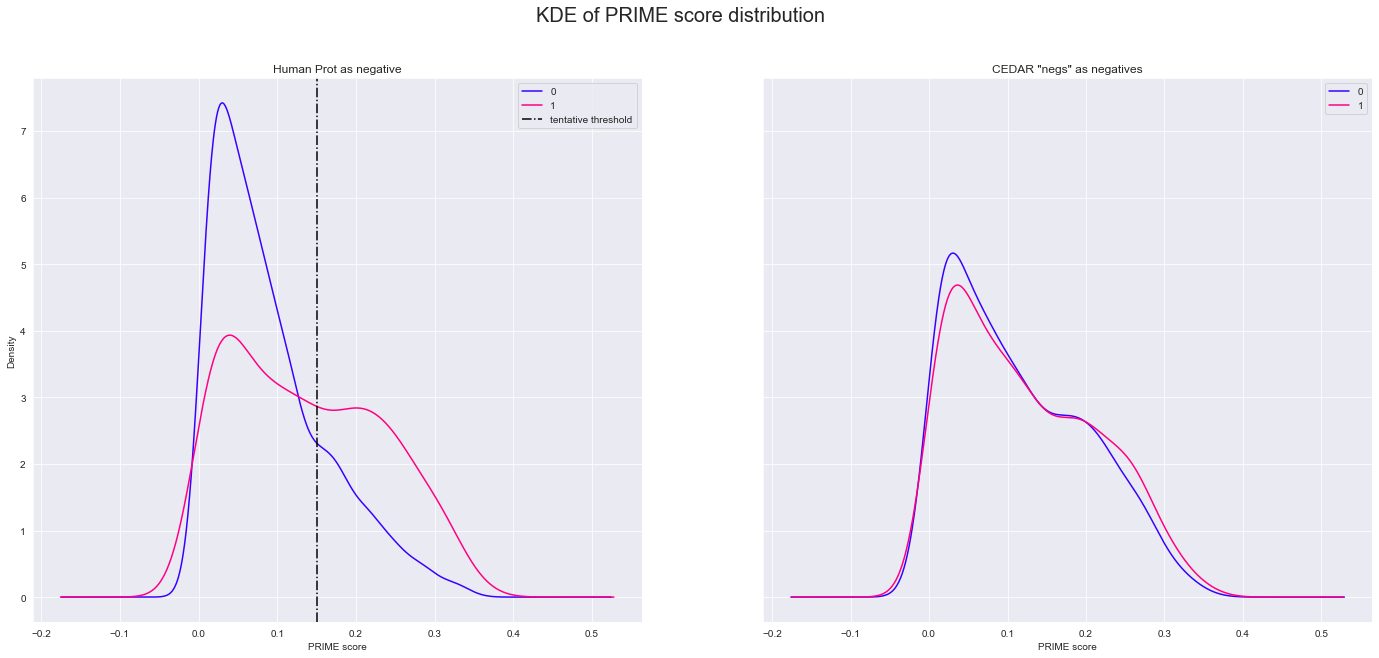

In [209]:
%matplotlib inline
f,a = plt.subplots(1,2, figsize=(24,10),sharey=True)# dpi =180)

merged_results.groupby('agg_label')['Score_bestAllele'].plot(title='Human Prot as negative',kind='kde',legend='agg_label', ax=a[0], xlabel='PRIME score')
merged_cedar.groupby('agg_label')['Score_bestAllele'].plot(title='CEDAR "negs" as negatives',kind='kde',legend='agg_label', ax=a[1], xlabel='PRIME score')
a[0].set_xlabel('PRIME score')
a[0].axvline(0.15, label = 'tentative threshold', color='k',ls='-.')
a[0].legend()
a[1].set_xlabel('PRIME score')
f.suptitle('KDE of PRIME score distribution', fontweight = 2, fontsize=20)

In [121]:
print('using human prot as neg')
display(merged_results.groupby('agg_label')['Score_bestAllele'].describe())
print('using only cedar as pos/neg')
display(merged_cedar.groupby('agg_label')['Score_bestAllele'].describe())

using human prot as neg


,count,mean,std,min,25%,50%,75%,max
agg_label,,,,,,,,
0,1953.0,0.089987,0.072259,0.000276,0.033245,0.069775,0.126270,0.349874
1,429.0,0.137497,0.094988,0.000368,0.051385,0.127872,0.211444,0.352159


using only cedar as pos/neg


,count,mean,std,min,25%,50%,75%,max
agg_label,,,,,,,,
0,1064.0,0.115402,0.085935,0.000287,0.038454,0.098637,0.182349,0.352944
1,623.0,0.123307,0.089546,0.000324,0.044187,0.108331,0.194269,0.352052


In [ ]:
A0101.tar.gz A0201.tar.gz A0202.tar.gz A0203.tar.gz A0206.tar.gz A0301.tar.gz A1101.tar.gz A2301.tar.gz A2402.tar.gz A2403.tar.gz A2601.tar.gz A2902.tar.gz A3001.tar.gz A3002.tar.gz A3101.tar.gz A3301.tar.gz A6801.tar.gz A6802.tar.gz A6901.tar.gz B0702.tar.gz B0801.tar.gz B1501.tar.gz B1801.tar.gz B2705.tar.gz B3501.tar.gz B4001.tar.gz B4002.tar.gz B4402.tar.gz B4403.tar.gz B4501.tar.gz B5101.tar.gz B5301.tar.gz B5401.tar.gz B5701.tar.gz B5801.tar.gz

In [493]:
[x for x in df_tc.columns if 'assay' in x]

['assay_location of assay data in the manuscript',
 'assay_method/technique',
 'assay_assay group',
 'assay_units',
 'assay_qualitative measure',
 'assay_measurement inequality',
 'assay_quantitative measurement',
 'assay_number of subjects tested',
 'assay_number of subjects responded',
 'assay_response frequency',
 'tcr_assayed tcr molecule name',
 'assay antigen_antigen epitope relation',
 'assay antigen_antigen object type',
 'assay antigen_antigen description',
 'assay antigen_starting position',
 'assay antigen_ending position',
 'assay antigen_non-peptidic antigen chebi id',
 'assay antigen_antigen source molecule name',
 'assay antigen_protein parent name',
 'assay antigen_protein parent accession',
 'assay antigen_antigen organism name',
 'assay antigen_organism species name',
 'assay antigen_organism species id',
 'assay comments_assay comments']

In [501]:
df_tc.query('epitope_description=="FLFLRNFSL"')

,reference_t cell id,reference_reference id,reference_type,reference_pubmed id,reference_authors,reference_journal,reference_date,reference_title,reference_submission id,epitope_epitope id,epitope_object type,epitope_description,epitope_starting position,epitope_ending position,epitope_non-peptidic epitope chebi id,epitope_antigen name,epitope_parent protein,epitope_parent protein accession,epitope_organism name,epitope_parent species,epitope_parent species id,epitope_epitope comments,related object_epitope relationship,related object_object type,related object_description,related object_starting position,related object_ending position,related object_non-peptidic object accession,related object_synonyms,related object_antigen name,related object_parent protein,related object_organism name,related object_parent organism,host_name,host_host id,host_geolocation,host_mhc types present,1st in vivo process_process type,1st in vivo process_disease state,1st in vivo process_disease stage,1st in vivo process_immunogen epitope relation,1st in vivo process_immunogen object type,1st in vivo process_immunogen description,1st in vivo process_immunogen starting position,1st in vivo process_immunogen ending position,1st in vivo process_non-peptidic immunogen chebi id,1st in vivo process_immunogen source molecule name,1st in vivo process_immunogen protein parent name,1st in vivo process_immunogen protein parent accession,1st in vivo process_immunogen organism name,1st in vivo process_immunogen organism species,1st in vivo process_immunogen organism species accession,2nd in vivo process_process type,2nd in vivo process_disease state,2nd in vivo process_disease stage,2nd in vivo process_immunogen epitope relation,2nd in vivo process_immunogen object type,2nd in vivo process_immunogen description,2nd in vivo process_immunogen starting position,2nd in vivo process_immunogen ending position,2nd in vivo process_non-peptidic immunogen chebi id,2nd in vivo process_immunogen source molecule name,2nd in vivo process_immunogen protein parent name,2nd in vivo process_immunogen protein parent accession,2nd in vivo process_immunogen organism name,2nd in vivo process_immunogen organism species,2nd in vivo process_immunogen organism species accession,in vitro process_in vitro process type,in vitro process_responder cell type,in vitro process_stimulator cell type,in vitro process_immunogen epitope relation,in vitro process_immunogen object type,in vitro process_immunogen description,in vitro process_non-peptidic immunogen chebi id,in vitro process_immunogen source molecule name,in vitro process_protein parent name,in vitro process_protein parent accession,in vitro process_immunogen organism name,in vitro process_immunogen organism species,in vitro process_immunogen organism species id,adoptive transfer_adoptive transfer flag,adoptive transfer_adoptive transfer comments,immunization comments_immunization comments,assay_location of assay data in the manuscript,assay_method/technique,assay_assay group,assay_units,assay_qualitative measure,assay_measurement inequality,assay_quantitative measurement,assay_number of subjects tested,assay_number of subjects responded,assay_response frequency,effector cells_cell tissue type,effector cells_cell type,effector cells_cell culture conditions,tcr_assayed tcr molecule name,tcr_pdb id,antigen presenting cells_cell tissue type,antigen presenting cells_cell type,antigen presenting cells_cell culture conditions,mhc_allele name,mhc_class,mhc_allele evidence code,assay antigen_antigen epitope relation,assay antigen_antigen object type,assay antigen_antigen description,assay antigen_starting position,assay antigen_ending position,assay antigen_non-peptidic antigen chebi id,assay antigen_antigen source molecule name,assay antigen_protein parent name,assay antigen_protein parent accession,assay antigen_antigen organism name,assay antigen_organism species name,assay antigen_organism species id,assay comments_assay comments
10,2464,458

In [500]:
df_tc[['epitope_description', 'related object_description', 'assay_method/technique']].dropna(axis=0)

,epitope_description,related object_description,assay_method/technique
10,FLFLRNFSL,FVFLRNFSL,multimer/tetramer
11,FLFLRNFSL,FVFLRNFSL,51 chromium
16,FLPSPLFFFL,FPPSPLFFFL,51 chromium
17,FLPSPLFFFL,FPPSPLFFFL,multimer/tetramer
18,FLPSPLFFFL,FPPSPLFFFL,51 chromium
...,...,...,...
10157,VARLSSKSV,VARLSSKSV,ELISA
10166,GLLVHPQWV,GVLVHPQWV,ELISPOT
10167,GLLVHPQWV,GVLVHPQWV,ELISPOT
10168,REEMEVHEL,RDRSHREEM,biological activity


In [130]:
import numpy as np 
from scipy.stats import t


def bootstrap_CI(data, nbr_draws):
    means = np.zeros(nbr_draws)
    data = np.array(data)

    for n in range(nbr_draws):
        indices = np.random.randint(0, len(data), len(data))
        data_tmp = data[indices] 
        means[n] = np.nanmean(data_tmp)

    return [np.nanpercentile(means, 2.5),np.nanpercentile(means, 97.5)]

CI_mixed_pos = bootstrap_CI(merged_results.query('agg_label==1')['Score_bestAllele'].values, 100000)
CI_cedar_pos = bootstrap_CI(merged_cedar.query('agg_label==1')['Score_bestAllele'].values, 100000)

CI_mixed_neg = bootstrap_CI(merged_results.query('agg_label==0')['Score_bestAllele'].values, 100000)
CI_cedar_neg = bootstrap_CI(merged_cedar.query('agg_label==0')['Score_bestAllele'].values, 100000)

print(f'mixed CI95%: \npos\t{CI_mixed_pos}\nneg\t{CI_mixed_neg}')
print(f'cedar CI95%: \npos\t{CI_cedar_pos}\nneg\t{CI_cedar_neg}')

mixed CI95%: 
pos	[0.12860928531468532, 0.14645403263403264]
neg	[0.08681394984639017, 0.09319676684587815]
cedar CI95%: 
pos	[0.11628589791332261, 0.13035689486356342]
neg	[0.1102557103618421, 0.12060405049342107]


In [142]:
import seaborn as sns
cols = sns.color_palette('hsv', n_colors=13)
sns.set_palette((cols[-4], cols[-1]))
sns.set_style('darkgrid')
merged_results['dataset']='HP_cedar'
merged_cedar['dataset']='cedar_only'
total = pd.concat([merged_results, merged_cedar], ignore_index=True)

<AxesSubplot:xlabel='dataset', ylabel='%RankBinding_bestAllele'>

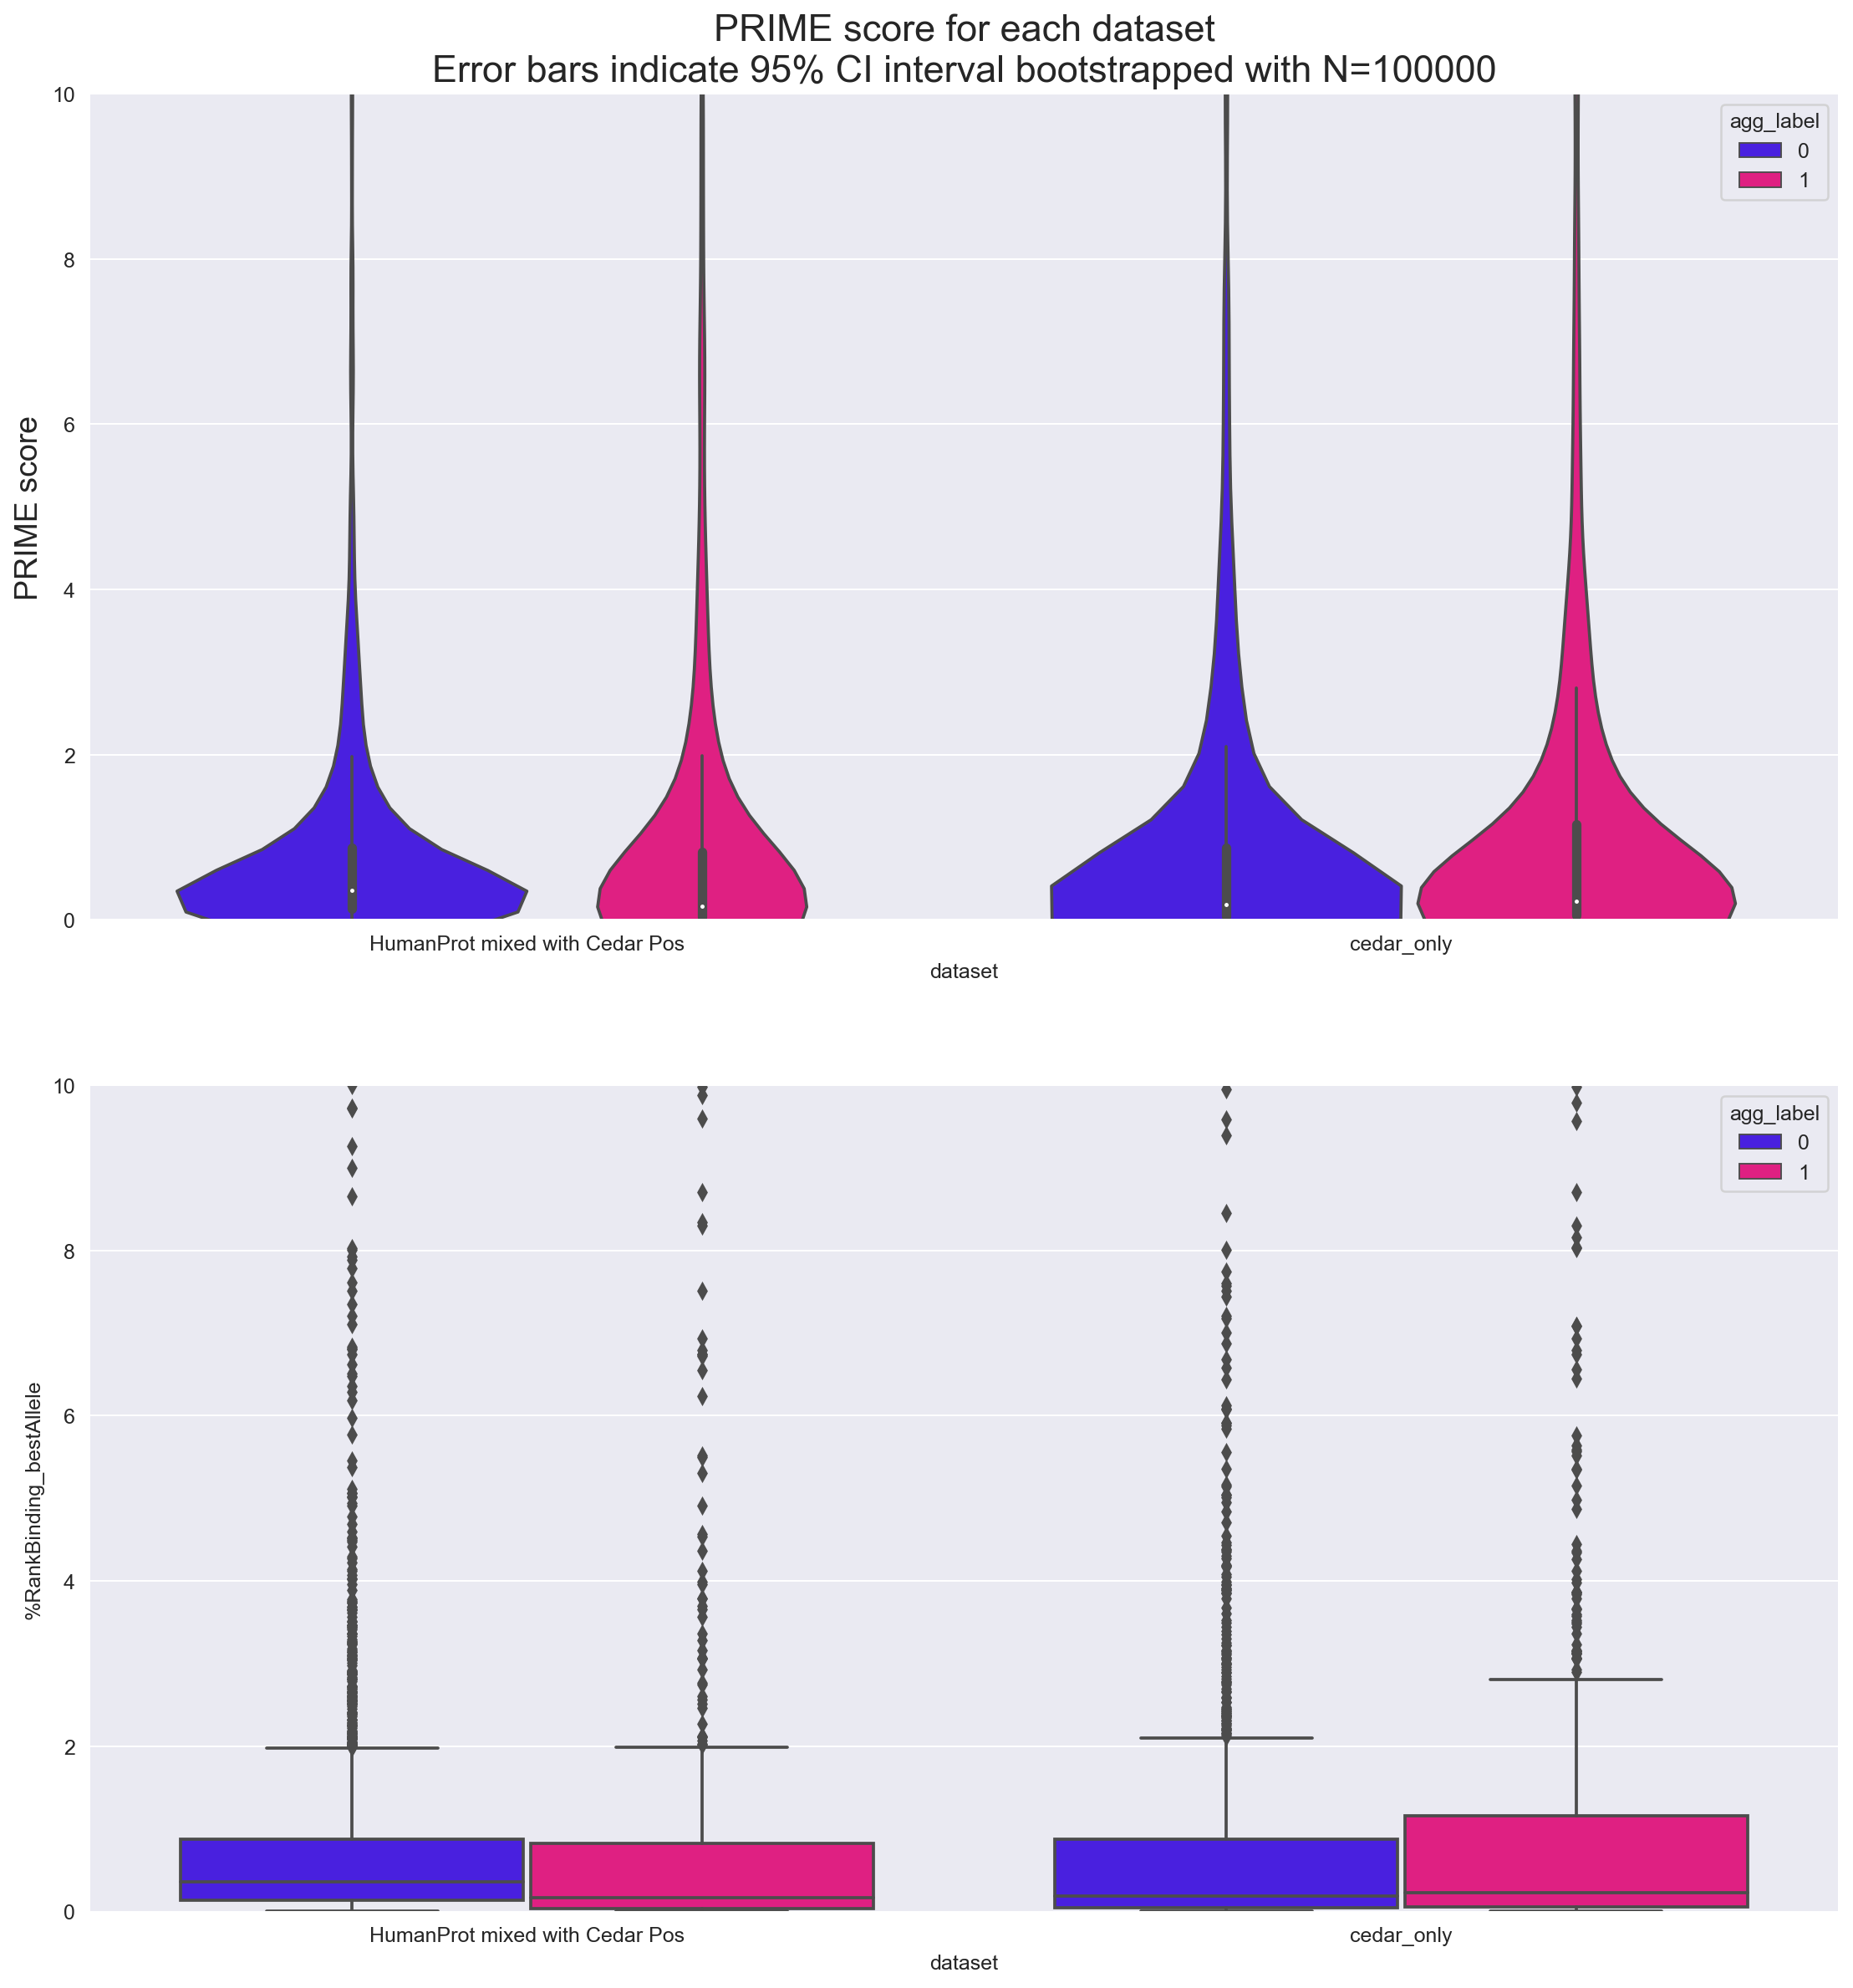

In [216]:
f,a = plt.subplots(2,1, figsize=(15,16), dpi=180)
sns.violinplot(data = total.replace({'HP_cedar':'HumanProt mixed with Cedar Pos'}),
            x = 'dataset', y = '%RankBinding_bestAllele', hue='agg_label', 
            ci=95, n_boot=10000, seed=1, ax=a[0], errcolor='k', capsize=0.025, alpha=0.75)
a[0].set_title('PRIME score for each dataset\nError bars indicate 95% CI interval bootstrapped with N=100000', fontsize=18)
a[0].set_ylabel('PRIME score', fontsize=15, fontweight=2.5)
a[0].set_ylim([0, 10])
a[1].set_ylim([0, 10])

sns.boxplot(data=total.replace({'HP_cedar':'HumanProt mixed with Cedar Pos'}),
            x = 'dataset', y = '%RankBinding_bestAllele', hue='agg_label', ax=a[1])


<AxesSubplot:xlabel='dataset', ylabel='Score_bestAllele'>

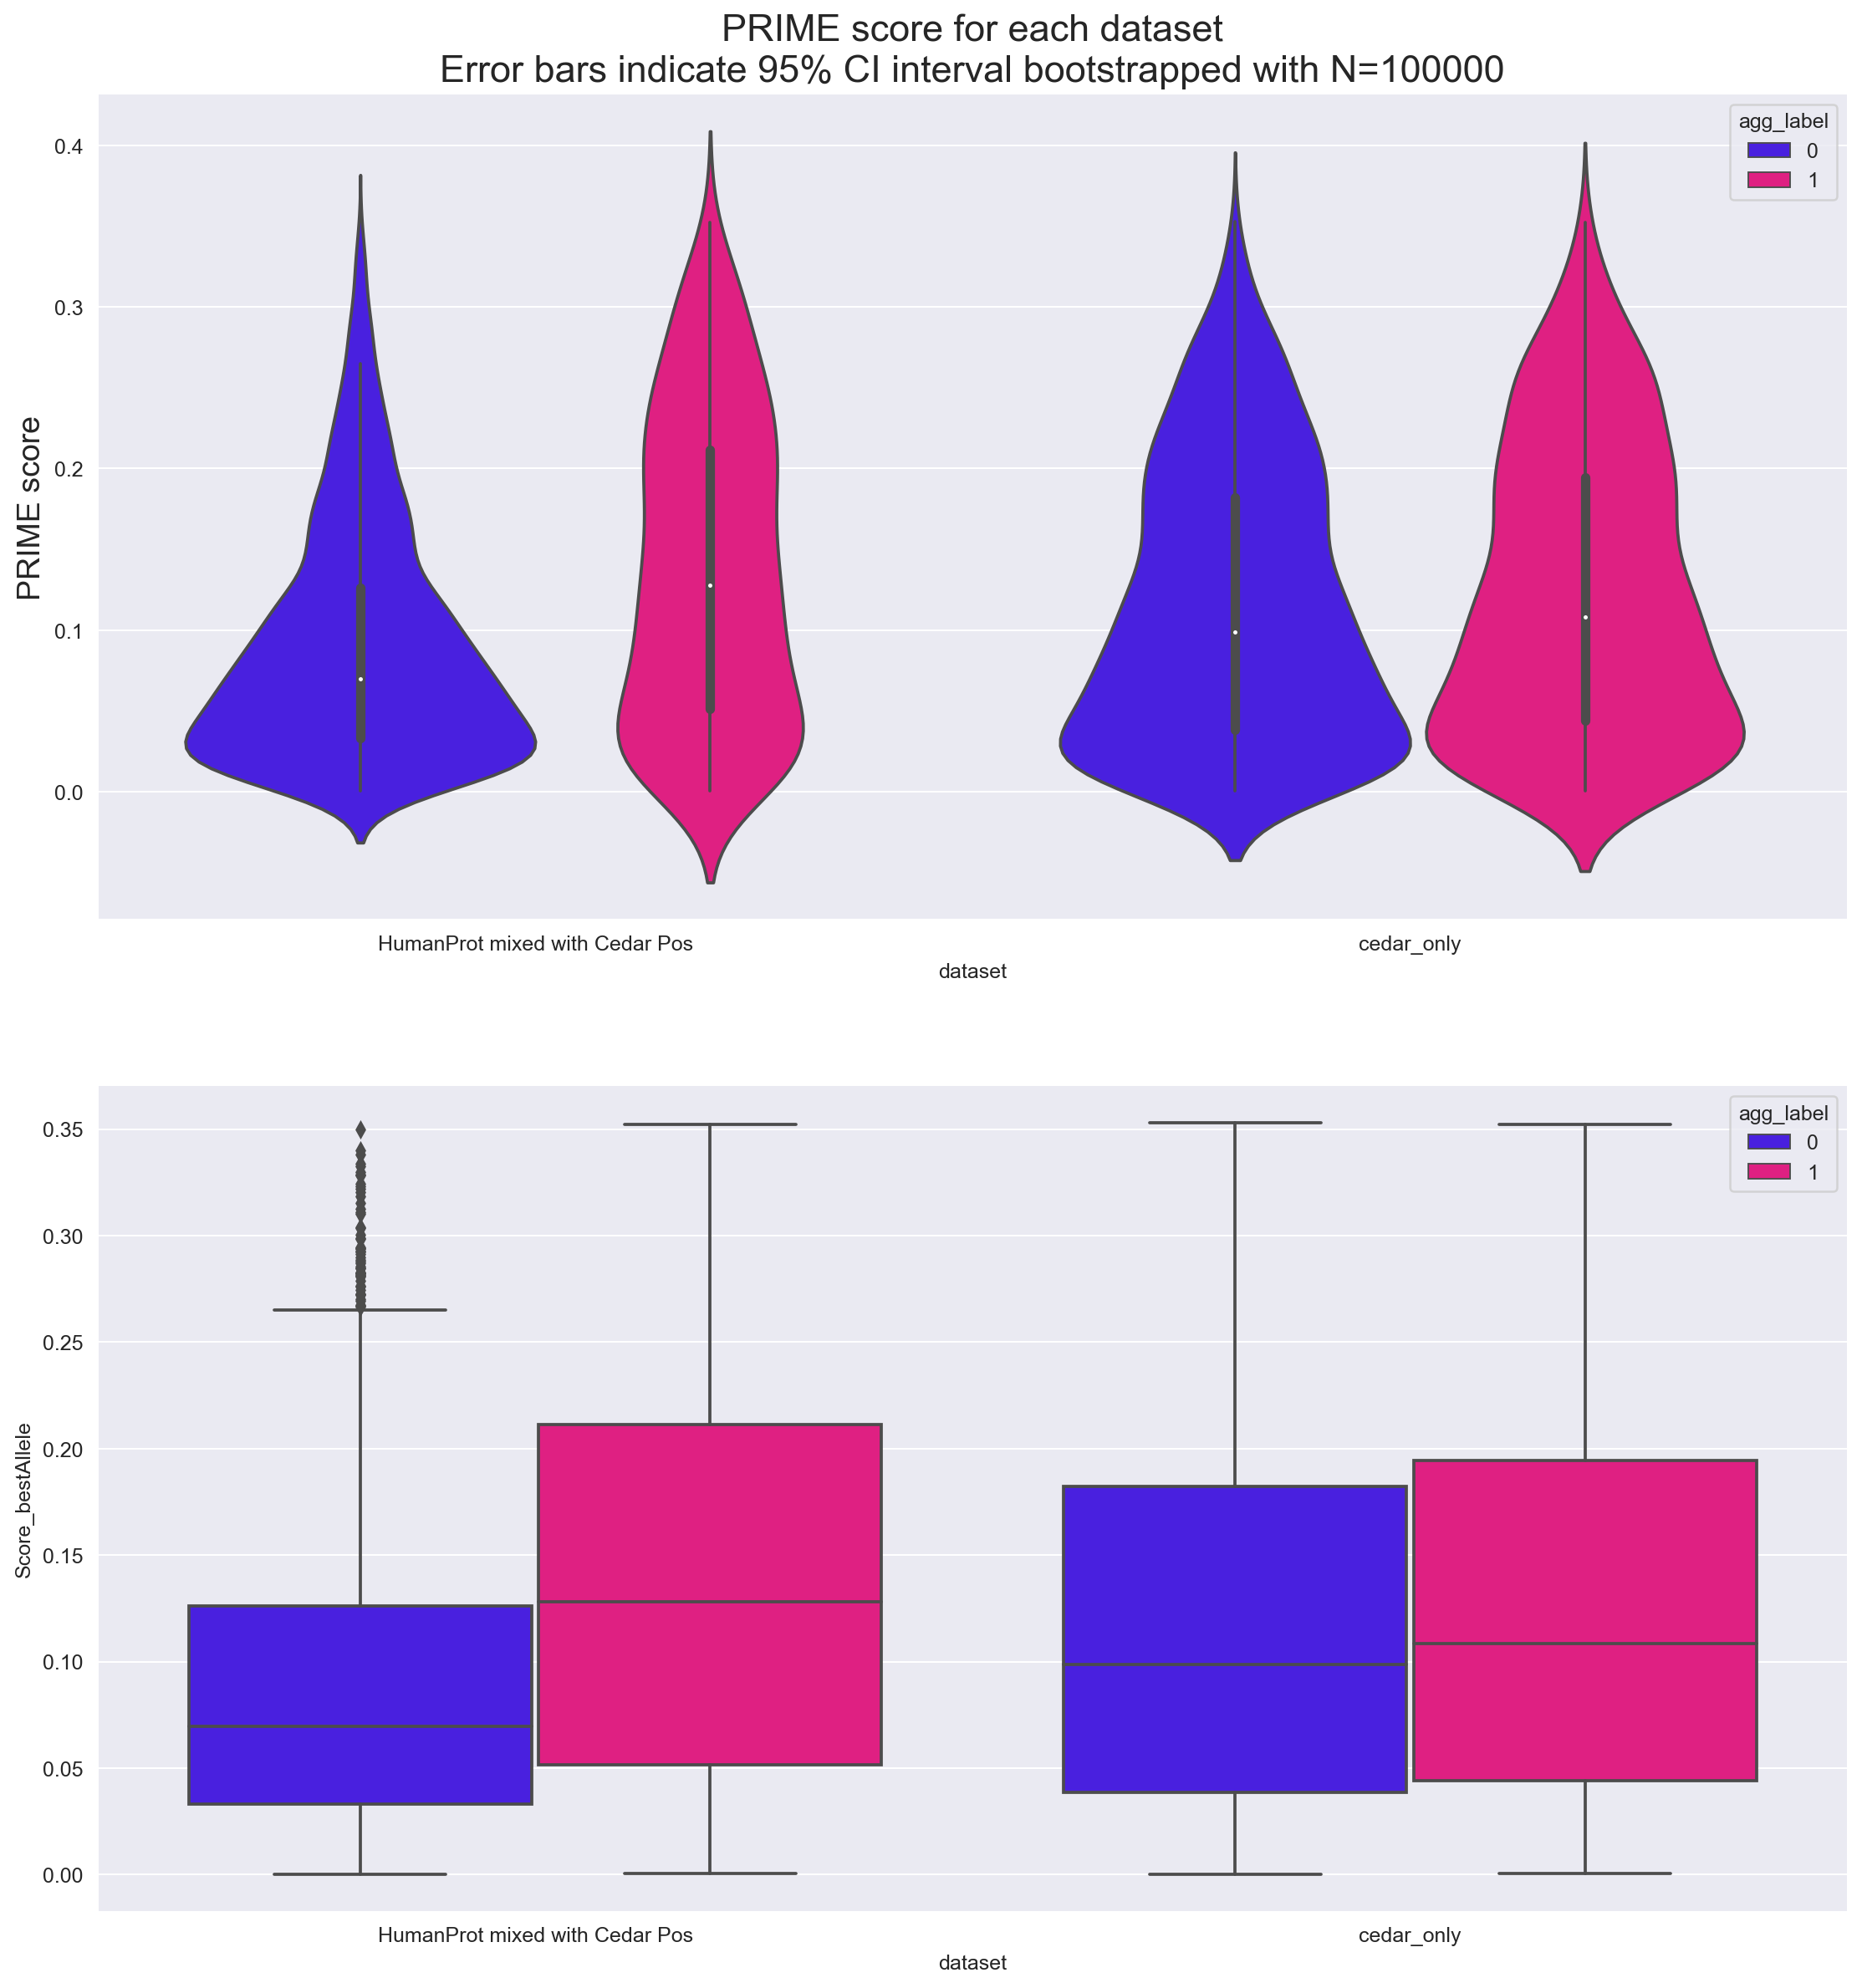

In [182]:
f,a = plt.subplots(2,1, figsize=(15,16), dpi=180)
sns.violinplot(data = total.replace({'HP_cedar':'HumanProt mixed with Cedar Pos'}),
            x = 'dataset', y = 'Score_bestAllele', hue='agg_label', 
            ci=95, n_boot=10000, seed=1, ax=a[0], errcolor='k', capsize=0.025, alpha=0.75)
a[0].set_title('PRIME score for each dataset\nError bars indicate 95% CI interval bootstrapped with N=100000', fontsize=18)
a[0].set_ylabel('PRIME score', fontsize=15, fontweight=2.5)
sns.boxplot(data=total.replace({'HP_cedar':'HumanProt mixed with Cedar Pos'}),
            x = 'dataset', y = 'Score_bestAllele', hue='agg_label', ax=a[1])


In [201]:
from statsmodels.stats.weightstats import ttest_ind as ttest
from scipy import stats

t_pval_hp = stats.mannwhitneyu(total.query('dataset=="HP_cedar" & agg_label==0')['Score_bestAllele'].values,
                               total.query('dataset=="HP_cedar" & agg_label==1')['Score_bestAllele'].values, 
                               alternative='greater')

t_pval_cedar = stats.mannwhitneyu(total.query('dataset=="cedar_only" & agg_label==0')['Score_bestAllele'].values,
                               total.query('dataset=="cedar_only" & agg_label==1')['Score_bestAllele'].values, 
                               alternative='greater')
print(f'Mann-Whitney-U test for diff distribution in PRIME score for HP+cedar:\n\t{t_pval_hp}')
print(f'Mann-Whitney-U test for diff distribution in PRIME score for cedar_only:\n\t{t_pval_cedar}')

Mann-Whitney-U test for diff distribution in PRIME score for HP+cedar:
	MannwhitneyuResult(statistic=301102.5, pvalue=1.0)
Mann-Whitney-U test for diff distribution in PRIME score for cedar_only:
	MannwhitneyuResult(statistic=315582.0, pvalue=0.9496928381642089)


In [202]:
print('Student t-test for diff mean in PRIME score HP+cedar\n\t',stats.ttest_ind(total.query('dataset=="HP_cedar" & agg_label==0')['Score_bestAllele'].values,
                         total.query('dataset=="HP_cedar" & agg_label==1')['Score_bestAllele'].values, 
                         alternative='greater'))
print('Student t-test for diff mean in PRIME score cedar only\n\t',stats.ttest_ind(total.query('dataset=="cedar_only" & agg_label==0')['Score_bestAllele'].values,
                         total.query('dataset=="cedar_only" & agg_label==1')['Score_bestAllele'].values, 
                         alternative='greater'))

Student t-test for diff mean in PRIME score HP+cedar
	 Ttest_indResult(statistic=-11.595299507791294, pvalue=1.0)
Student t-test for diff mean in PRIME score cedar only
	 Ttest_indResult(statistic=-1.7950009881207678, pvalue=0.9635836503929425)


## ROC AUC

In [466]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
cedar_hp = merged_results[['Score_bestAllele', 'agg_label']].values
cedar_only = merged_cedar[['Score_bestAllele', 'agg_label']].values

Text(0.5, 1.0, 'Roc AUC based on PRIME prediction score')

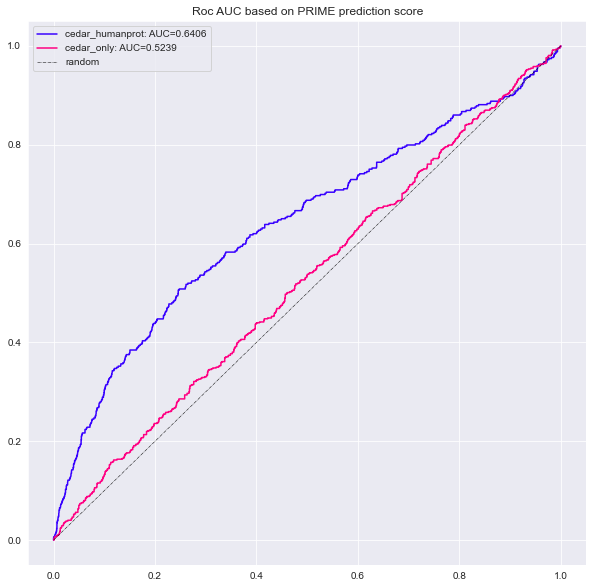

In [482]:
f,a = plt.subplots(1,1, figsize=(10,10))
vals = {'cedar_humanprot':cedar_hp,
        'cedar_only':cedar_only}
for k,v in vals.items():
    fpr, tpr, thresholds = roc_curve(v[:,1], v[:,0])
    auc = roc_auc_score(v[:,1], v[:,0])
    a.plot(fpr, tpr, label=f'{k}: AUC={auc:.4f}')
dash=np.linspace(0,1,100)
a.plot(dash,dash, lw=0.5, ls='-.', color='k', label = 'random')
a.legend()
a.set_title('Roc AUC based on PRIME prediction score')

# Select new datasets for NN_align 

In [250]:
_ = count_class(filtered_df[['epitope_description', 'agg_label']])
_ = get_top_HLA(filtered_df, 10)

,epitope_description
agg_label,
0,1064
1,623


A0201,A2402,A0301,B2705,A1101,B0801,A0101,A0206,B0702,B3501


In [486]:
positives = filtered_df.query('agg_label==1').rename(columns={'mhc_allele name':'HLA',
                                                              'epitope_description':'Peptide'})
positives.groupby(['HLA']).agg({'Peptide': 'count'})\
                                    .sort_values('Peptide', ascending=False).head(12)

,Peptide
HLA,
HLA-A*02:01,316
HLA-A*24:02,62
HLA-A*11:01,24
HLA-B*07:02,20
HLA-B*40:01,15
HLA-B*27:05,12
HLA-A*03:01,12
HLA-B*15:01,11
HLA-A*02:06,10


In [291]:
dataset.groupby(['HLA','agg_label']).agg({'agg_label':'count'})\
       .rename(columns={'agg_label':'count'})

count
HLA        agg_label       
HLA-A01:01 0            140
           1              6
HLA-A02:01 0            225
           1            316
HLA-A02:03 1              4
HLA-A02:05 1              2
HLA-A02:06 0            220
           1             10
HLA-A02:10 1              1
HLA-A02:11 1              2
HLA-A02:24 1              1
HLA-A03:01 0            145
           1             12
HLA-A03:02 1              1
HLA-A11:01 0            179
           1             24
HLA-A11:02 1              4
HLA-A24:02 0            201
           1             62
HLA-A25:01 1              5
HLA-A26:01 1              2
HLA-A29:02 1              6
HLA-A30:01 1              3
HLA-A30:02 1              2
HLA-A31:01 1              8
HLA-A33:01 1              1
HLA-A68:01 1              3
HLA-A68:02 1              1
HLA-A69:01 1              1
HLA-A80:01 1              1
HLA-B07:02 0            257
           1             19
HLA-B08:01 1              2
HLA-B15:01 0            168
           1             11
HLA-B18:01 1              3
HLA-B27:02 1              1
HLA-B27:05 0            231
           1             12
HLA-B35:01 0            187
           1             10
HLA-B35:03 1              1
HLA-B37:01 1              2
HLA-B37:04 1              1
HLA-B38:01 1              4
HLA-B39:01 1              3
HLA-B39:06 1              1
HLA-B40:01 1             15
HLA-B40:02 1              1
HLA-B41:02 1              1
HLA-B44:02 1              3
HLA-B44:03 1              7
HLA-B49:01 1              1
HLA-B51:01 1              4
HLA-B54:01 1              1
HLA-B56:01 1              1
HLA-B57:01 1              3
HLA-C01:02 1              1
HLA-C03:03 1              5
HLA-C03:04 1              5
HLA-C04:01 1              1
HLA-C05:01 1              5
HLA-C06:02 1              7
HLA-C07:01 1              1
HLA-C07:02 1              1
HLA-C14:02 1              1
HLA-C14:03 1              3
HLA-C15:02 1              7

In [315]:
filtered_df.to_csv('../../../cedar_filtered.pep', index=False, header=False, columns = ['epitope_description'])
filtered_df.rename(columns={'epitope_description':'Peptide',
                            'mhc_allele name': 'HLA'}, inplace=True)
filtered_df[COLS].to_csv('../data/cedar_filtered.csv', index=False)

filtered_df.groupby(['mhc_allele name', 'agg_label'])[['epitope_description']].count().loc['HLA-A*02:06']

,epitope_description
agg_label,
0,29
1,10


In [392]:
# HUMAN PROT NEGS DIDNT SCORE FOR HLA-B*40:01
# SHOULD MAYBE REDO IT
hla_list= [x for x in positives.groupby('mhc_allele name').agg({'epitope_description': 'count'})\
                                     .sort_values('epitope_description', ascending=False).head(10).index]
_hla_list = [x.replace('*','') for x in hla_list]
import math
negs_hp = []
for k in 9,10:
    for hla in hla_list:
        _hla = hla.replace('*','')
        tmp = scored[k].query("HLA==@_hla")
        if len(tmp)==0:continue
        n = min(len(tmp), math.floor(5*len(positives.query('`mhc_allele name` == @hla'))))
        negs_hp.append(tmp.sample(n, random_state=13))
negs_hp = pd.concat(negs_hp)
# Then run Hobohm1 to filter through these negatives
negs_hp.to_csv('../../../human_proteome_negs_n5_rs13.pep', index=False, header=False,columns = ['Peptide'])
# copy to computerome and run hoboh1m_pepkernel


In [401]:
# Used Hobohm to remove redundancy
negs_n5_hp_hobohm = pd.read_csv('./hp_n5_hobohm1_bl62_t0825_st1.txt', header=None, index_col=None).rename(columns={0:'Peptide'})
negs_hp.merge(negs_n5_hp_hobohm, left_on ='Peptide', right_on='Peptide').to_csv('../data/human_proteome_negs_n5_hobohm1_rs13', index=None)

In [402]:
neg_cedar_all = filtered_df.query('agg_label==0')
neg_cedar_2 = filtered_df.query('agg_label==0 and total_count>=2')
neg_hp = pd.read_csv('../data/human_proteome_negs_n5_hobohm1_rs13')
# concat & saving
dataset_all = pd.concat([neg_cedar_all, positives])
dataset_filtered = pd.concat([neg_cedar_2, positives])
dataset_hp_hobohm = pd.concat([neg_hp, positives])
dataset_all.to_csv('../data/dataset_all.csv', index=None)
dataset_filtered.to_csv('../data/dataset_filtered.csv', index=None)
dataset_hp_hobohm.to_csv('../data/dataset_hp_hobohm.csv', index=None)

In [431]:
','.join(_hla_list)

'HLA-A02:01,HLA-A24:02,HLA-A11:01,HLA-B07:02,HLA-B40:01,HLA-B27:05,HLA-A03:01,HLA-B15:01,HLA-A02:06,HLA-B35:01'

In [426]:
COLS2 = COLS.copy()
COLS2[COLS.index('mhc_allele name')] = 'HLA'
COLS2[COLS.index('epitope_description')] = 'Peptide'
filtered_df[COLS2].HLA.unique()

array(['HLA-A*02:01', 'HLA-C*12:03', 'HLA-C*16:01', 'HLA-A*02:06',
       'HLA-B*08:01', 'HLA-A*11:01', 'HLA-B*44:03', 'HLA-B*47:01',
       'HLA-B*40:01', 'HLA-A*68:01', 'HLA-B*44:02', 'HLA-A*03:01',
       'HLA-B*15:01', 'HLA-A*11:02', 'HLA-A*23:01', 'HLA-A*02:02',
       'HLA-B*07:02', 'HLA-B*35:01', 'HLA-A*32:01', 'HLA-B*27:05',
       'HLA-C*07:02', 'HLA-C*07:01', 'HLA-B*57:01', 'HLA-C*15:02',
       'HLA-A*25:01', 'HLA-A*68:02', 'HLA-A*31:01', 'HLA-A*02:05',
       'HLA-A*24:02', 'HLA-A*30:01', 'HLA-A*02:03', 'HLA-C*01:02',
       'HLA-A*02:07', 'HLA-A*01:03', 'HLA-A*01:01', 'HLA-C*14:03',
       'HLA-B*51:01', 'HLA-B*18:01', 'HLA-C*06:02', 'HLA-A*26:01',
       'HLA-A*33:01', 'HLA-A*66:01', 'HLA-C*03:04', 'HLA-B*40:02',
       'HLA-B*38:01', 'HLA-A*29:02', 'HLA-A*33:03', 'HLA-B*15:27',
       'HLA-C*03:03', 'HLA-C*05:01', 'HLA-A*02:24', 'HLA-B*54:01',
       'HLA-B*39:01', 'HLA-A*80:01', 'HLA-B*56:01', 'HLA-A*02:11',
       'HLA-B*37:01', 'HLA-A*02:10', 'HLA-B*41:02', 'HLA-C*02:

In [452]:
dataset_all.to_csv('../../../dataset_all.pep', index=None, header=None, columns=['epitope_description', 'agg_label'], sep ='\t')
dataset_filtered.to_csv('../../../dataset_filtered.pep', index=None, header=None, columns=['epitope_description', 'agg_label'], sep ='\t')

# dataset_hp_hobohm.to_csv('../../../dataset_hp_hobohm.pep', index=None, header=None, columns=['epitope_description'])
# can't deal with this rename bs rn so just saving the peps
negs_hp['agg_label']=0
pd.concat([negs_hp, positives.rename(columns={'epitope_description':'Peptide','mhc_allele name':'HLA'})])\
         .to_csv('../../../dataset_hp_hobohm.pep',
                 index=None, header=None, columns=['Peptide', 'agg_label'], sep='\t')